# Prediction of No-SHOWS for medical appointments using Neural Network

![NoShows](http://magazine.dentrix.com/wp-content/uploads/DOM_2-5-20_Header.jpg)

## Importing Packages

In [1]:
import pandas as pd

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import os
import tensorflow
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics

## Import dataset

In [2]:
dataset = pd.read_csv('/kaggle/input/healthcare-appointment-dataset/dataset_modified.csv')
dataset.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,Showed_up,Date.diff
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,False,True,False,False,False,False,True,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,False,False,False,False,False,True,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,False,False,False,False,False,False,True,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,False,False,False,False,False,False,True,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,False,True,True,False,False,False,True,0


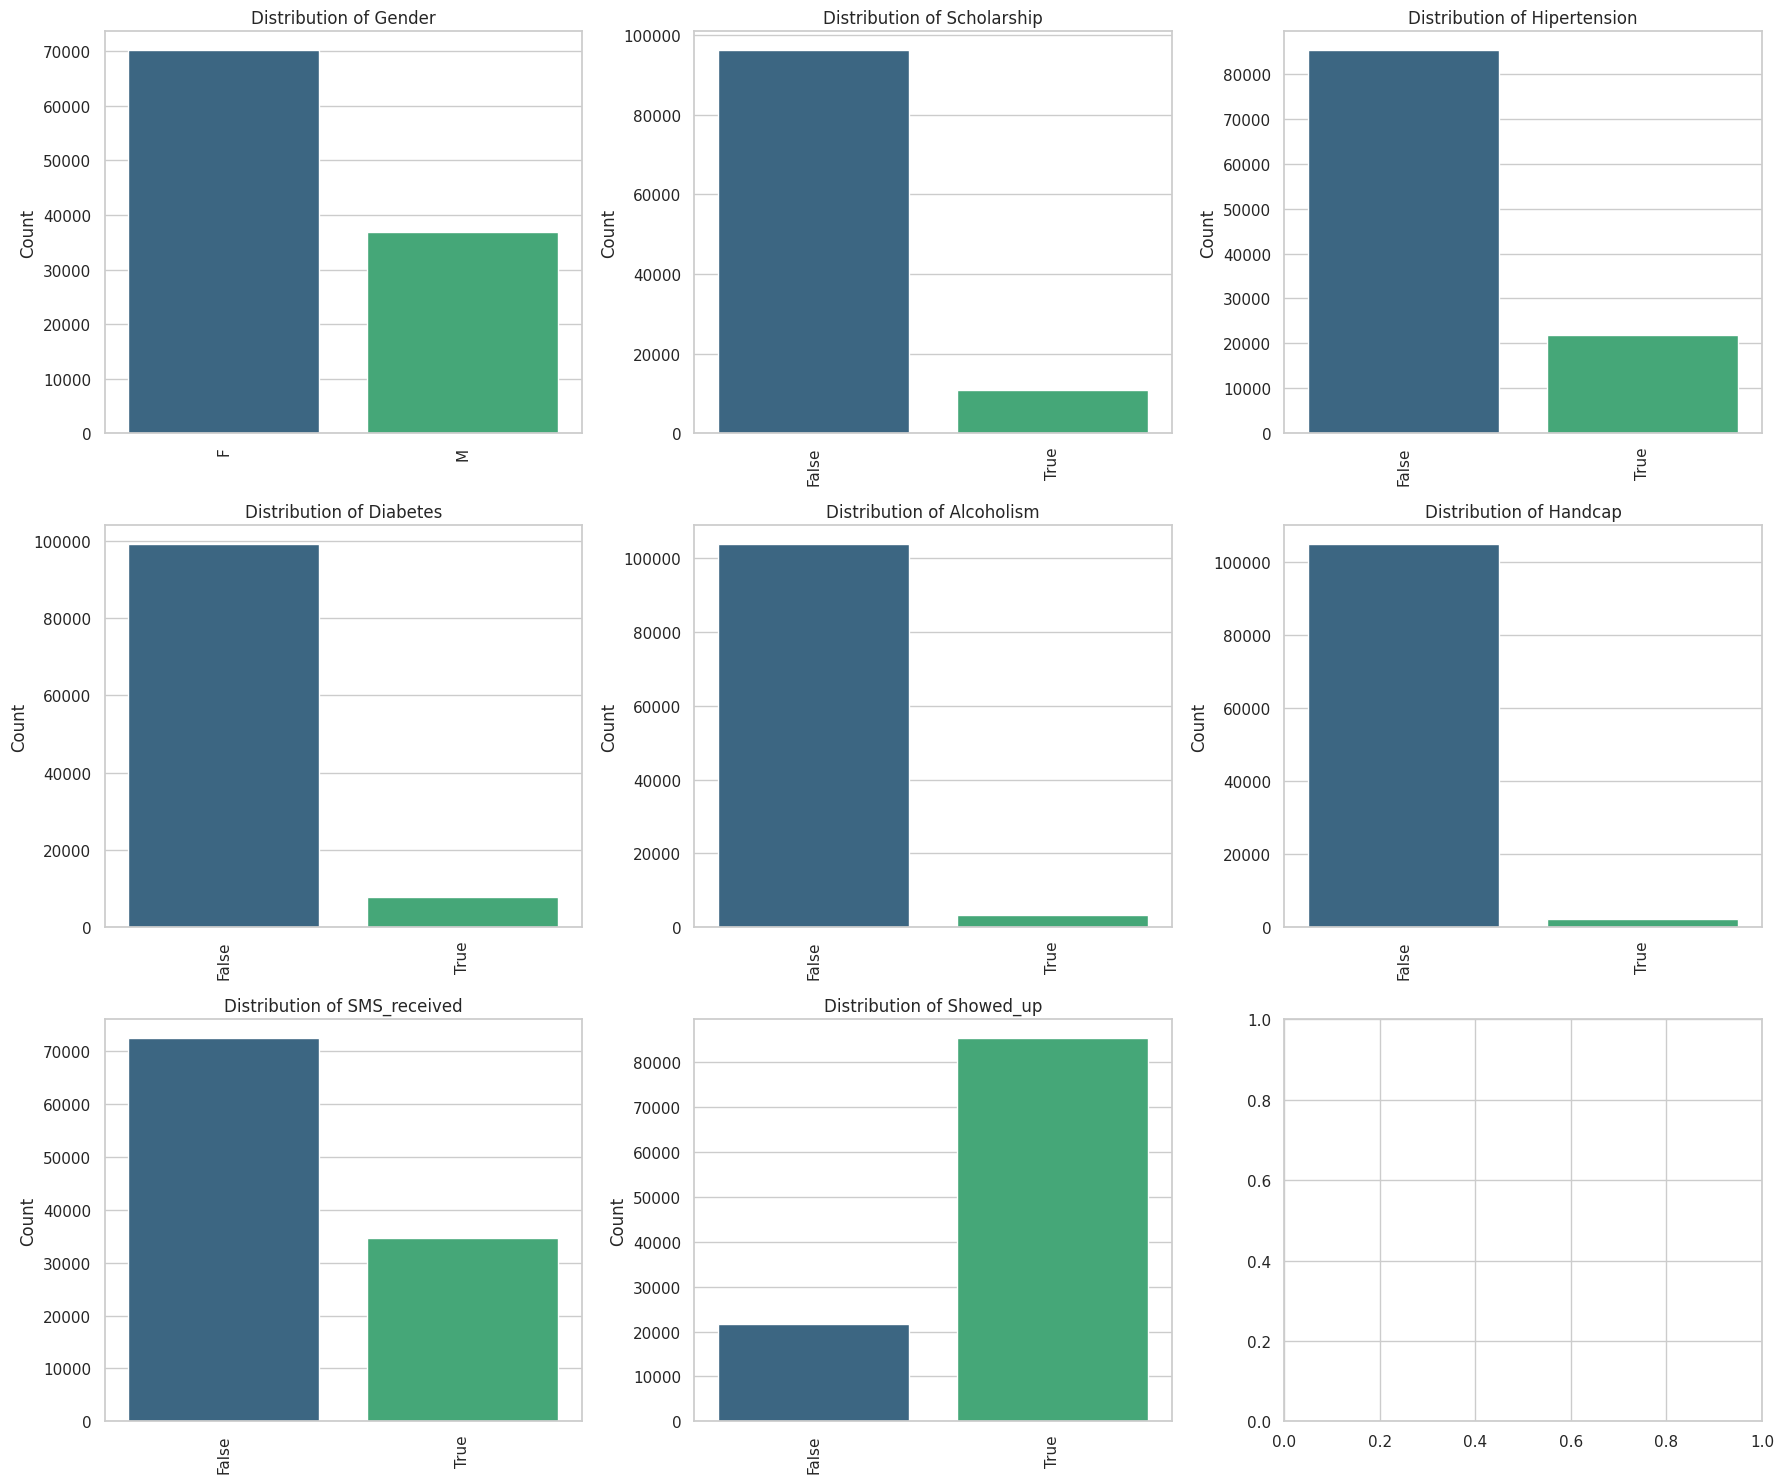

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# List of categorical features
categorical_features = ['Gender', 'Scholarship', 'Hipertension', 
                        'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up']

# Create a figure to hold subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each categorical feature
for i, feature in enumerate(categorical_features):
    sns.countplot(data=dataset, x=feature, ax=axes[i], palette="viridis")
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


## Data engineering

I'll remove unnecessary columns, map some categorical columns to seprate columns. Then, I'll split the data into test and train data.
I'll use `StandardScaler` function to scale the data as well.

If a person has missed an appointment before, there are chances he/she might miss again. Let's see if that is correlated.
I found this idea from a kernel on [Kaggle](https://www.kaggle.com/belagoesr/predicting-no-show-downsampling-approach-with-rf).

In [4]:
missed_appointment = dataset.groupby('PatientId')['Showed_up'].sum()
missed_appointment = missed_appointment.to_dict()
dataset['missed_appointment_before'] = dataset.PatientId.map(lambda x: 1 if missed_appointment[x]>0 else 0)
dataset['missed_appointment_before'].corr(dataset['Showed_up'])

0.6102086525921399

Surprisingly the correlation is really high and we should keep this column.

As we don't need all the columns, I'll start ommiting them.

In [5]:
dataset = dataset.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis = 1)
print("Columns: {}".format(dataset.columns))

Columns: Index(['Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up',
       'Date.diff', 'missed_appointment_before'],
      dtype='object')


Let's great dummy columns to accomodate all neighborhoods.

In [6]:
dataset = pd.concat([dataset.drop('Neighbourhood', axis = 1), 
           pd.get_dummies(dataset['Neighbourhood'])], axis=1)

Now, let's map the Gender column to random values, here 'M' as 0 and 'F' as 1.

In [7]:
gender_map = {'M': 0, 'F': 1}
dataset['Gender'] = dataset['Gender'].map(gender_map)

Next, I'll split the dataset into train and test data.

In [8]:
y = dataset.loc[:, 'Showed_up']
X = dataset.drop(['Showed_up'], axis = 1)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [10]:
print("Final shape: {}".format(X_train.shape))

Final shape: (71681, 91)


Let's now scale the data to make it ready for the Neural Network.

In [11]:
standardScaler = StandardScaler()
X_train = standardScaler.fit_transform(X_train)
X_test = standardScaler.transform(X_test)

## Model generation

I'll develop an Artificial Neural Network to map the data to find patterns and eventually learn from it.

In [12]:
classifier = Sequential()
classifier.add(Dense(units = 512, activation = 'relu', input_dim = 91))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 1024, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 2048, activation = 'relu'))
classifier.add(Dropout(rate = 0.6))
classifier.add(Dense(units = 1, activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        47,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,673,665 (10.20 MB)

 Trainable params: 2,673,665 (10.20 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = classifier.fit(X_train, y_train, epochs = 5, validation_split = 0.1)

Epoch 1/5
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 52s 25ms/step - accuracy: 0.8634 - loss: 0.4193 - val_accuracy: 0.8825 - val_loss: 0.3391
Epoch 2/5
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.8808 - loss: 0.3561 - val_accuracy: 0.8825 - val_loss: 0.3436
Epoch 3/5
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.8837 - loss: 0.3489 - val_accuracy: 0.8827 - val_loss: 0.3355
Epoch 4/5
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 51s 25ms/step - accuracy: 0.8851 - loss: 0.3415 - val_accuracy: 0.8827 - val_loss: 0.3403
Epoch 5/5
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 83s 26ms/step - accuracy: 0.8820 - loss: 0.3457 - val_accuracy: 0.8827 - val_loss: 0.3374


## Model prediction

As the model is now ready and trained, let's test on the test data.
For a baseline, I'll also write the difference between the two classes in the test data.

In [14]:
y_pred = classifier.predict(X_test)
y_pred = y_pred > 0.5

1104/1104 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [15]:
print("Test data description:")
print("{}".format(y_test.value_counts()))
print("-"*50)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Test data description:
Showed_up
True     28147
False     7159
Name: count, dtype: int64
--------------------------------------------------
Confusion matrix:
[[ 3032  4127]
 [    0 28147]]
Accuracy: 88.31%


## Conclusion

Using `ANN` with data engineering, I was able to achieve an accuracy of over 88% in predicting whether someone would show up or not for their appointment.